In [2]:
import networkx as nx
from networkx.algorithms.community.louvain import louvain_communities
# import pymetis

import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer

# from ipysigma import Sigma
# import umap
# import umap.plot
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
tqdm.pandas()


from src.EchoGAE import EchoGAE_algorithm
from src.tweet_preprocessing import preprocess_tweet_for_bert


from src.load_data import get_data


# disable warnings
import warnings
warnings.filterwarnings("ignore")
from networkx.algorithms.community import asyn_fluidc
from src.echo_chamber_measure import EchoChamberMeasure

# Baseline models
from src.baselines.RWC import RWC as RWC_jity
from src.baselines.polarization_index import add_ideology_to_graph, opinion_model, get_polarization_index, my_implementation_polarization_index

In [3]:
def add_ideology_to_graph_22(G, ideologies_dict):
    G = G.copy()
    core_nodes = []
    for node in G.nodes():
        if node in ideologies_dict:
            G.nodes[node]["ideology"] = ideologies_dict[node]
            core_nodes.append(node)
        else:
            G.nodes[node]["ideology"] = 0
    return G, core_nodes

In [4]:
def community_detection(G, k):
    adjacency_list = [np.array(list(G.neighbors(node))) for node in G.nodes()]

    _, membership = pymetis.part_graph(k, adjacency=adjacency_list)
    return membership

In [6]:
from sklearn.utils import check_random_state
import torch
import random


random.seed(42)

# Set the random seed for numpy
np.random.seed(42)

# Set the random seed for pandas
# pd.np.random.seed(42)

# Set the random seed for scikit-learn
check_random_state(42)

# Set the random seed for pytorch
torch.manual_seed(42)

In [7]:
datasets = ["gun", "abortion", "super_bowl", "sxsw"]

In [9]:
experiments = []
iter = 1

use_baseline = True

for ds in datasets:
    print(f"Dataset ({ds}):")
    for i in range(iter):
        print(f"Run {i+1}/{iter}: ", end="")
        ds_dict = {}
        ds_dict["dataset"] = ds

        # Get the data
        G, users_embeddings, labels, allsides_scores, node_id_map = get_data(f"data/{ds}/")

        # Graph information
        ds_dict["number_of_nodes"] = G.number_of_nodes()
        ds_dict["number_of_edges"] = G.number_of_edges()
        ds_dict["number_of_communities"] = len(np.unique(labels))


        # My metric
        user_emb = EchoGAE_algorithm(G, user_embeddings= users_embeddings, show_progress=True, hidden_channels = 20, out_channels=10, epochs=300)
        ecm = EchoChamberMeasure(user_emb, labels)
        eci = ecm.echo_chamber_index()
        ds_dict["echo_chamber_index"] = eci

        print(f"ECI = {eci:.3f} -- ", end=" ")

        # For communities ECIs and Sizes
        sizes = []
        ECIs = []

        for i in np.unique(labels):
            sizes.append(np.sum(labels == i))
            ECIs.append(ecm.community_echo_chamber_index(i))

        ds_dict["community_sizes"] = sizes
        ds_dict["community_ECIs"] = ECIs


        if use_baseline:
            # RWC metric
            # membership = community_detection(G, 2)
            # membership = np.array(membership)
            # nodes_0 = np.where(membership == 0)[0]
            # nodes_1 = np.where(membership == 1)[0]

            mem = asyn_fluidc(G, k=2, seed=42, max_iter=1000)
            mem = list(mem)

            nodes_0 = np.array(list(mem[0]))
            nodes_1 = np.array(list(mem[1]))


            rwc = RWC_jity(G, nodes_0, nodes_1)
            ds_dict["RWC"] = rwc
            print(f"RWC = {rwc:.3f} -- ", end=" ")


            # Valenzuela metric
            # G_ven, core_nodes = add_ideology_to_graph(G, membership, percentage=0.05)
            G_ven, core_nodes = add_ideology_to_graph_22(G, allsides_scores)
            opinions = opinion_model(G_ven, core_nodes=core_nodes)
            polarization_index = get_polarization_index(opinions)[0]

            ds_dict["Valenzuela"] = polarization_index
            print(f"Valenzuela = {polarization_index:.3f}")
        else:
            print("")

        experiments.append(ds_dict)

    print("\n")

Dataset (gun):
Run 1/1: Epoch: 001, AUC: 0.8911, AP: 0.8682
Epoch: 002, AUC: 0.8928, AP: 0.8697
Epoch: 003, AUC: 0.8932, AP: 0.8702
Epoch: 004, AUC: 0.8938, AP: 0.8703
Epoch: 005, AUC: 0.8958, AP: 0.8713
Epoch: 006, AUC: 0.8978, AP: 0.8722
Epoch: 007, AUC: 0.8999, AP: 0.8728
Epoch: 008, AUC: 0.9014, AP: 0.8731
Epoch: 009, AUC: 0.9021, AP: 0.8729
Epoch: 010, AUC: 0.9023, AP: 0.8726
Epoch: 011, AUC: 0.9023, AP: 0.8724
Epoch: 012, AUC: 0.9022, AP: 0.8722
Epoch: 013, AUC: 0.9022, AP: 0.8722
Epoch: 014, AUC: 0.9022, AP: 0.8720
Epoch: 015, AUC: 0.9020, AP: 0.8714
Epoch: 016, AUC: 0.9015, AP: 0.8704
Epoch: 017, AUC: 0.9008, AP: 0.8691
Epoch: 018, AUC: 0.8996, AP: 0.8674
Epoch: 019, AUC: 0.8980, AP: 0.8656
Epoch: 020, AUC: 0.8966, AP: 0.8646
Epoch: 021, AUC: 0.8961, AP: 0.8642
Epoch: 022, AUC: 0.8962, AP: 0.8642
Epoch: 023, AUC: 0.8964, AP: 0.8644
Epoch: 024, AUC: 0.8958, AP: 0.8640
Epoch: 025, AUC: 0.8942, AP: 0.8628
Epoch: 026, AUC: 0.8918, AP: 0.8609
Epoch: 027, AUC: 0.8888, AP: 0.8584
Epoc

100%|██████████| 5463/5463 [01:38<00:00, 55.30it/s]


Epoch: 001, AUC: 0.7175, AP: 0.7554
Epoch: 002, AUC: 0.7247, AP: 0.7636
Epoch: 003, AUC: 0.7332, AP: 0.7709
Epoch: 004, AUC: 0.7491, AP: 0.7832
Epoch: 005, AUC: 0.7733, AP: 0.8002
Epoch: 006, AUC: 0.8105, AP: 0.8244
Epoch: 007, AUC: 0.8460, AP: 0.8479
Epoch: 008, AUC: 0.8584, AP: 0.8571
Epoch: 009, AUC: 0.8555, AP: 0.8560
Epoch: 010, AUC: 0.8485, AP: 0.8519
Epoch: 011, AUC: 0.8409, AP: 0.8469
Epoch: 012, AUC: 0.8326, AP: 0.8402
Epoch: 013, AUC: 0.8220, AP: 0.8302
Epoch: 014, AUC: 0.8104, AP: 0.8174
Epoch: 015, AUC: 0.7998, AP: 0.8047
Epoch: 016, AUC: 0.7920, AP: 0.7963
Epoch: 017, AUC: 0.7884, AP: 0.7934
Epoch: 018, AUC: 0.7887, AP: 0.7951
Epoch: 019, AUC: 0.7913, AP: 0.7987
Epoch: 020, AUC: 0.7960, AP: 0.8045
Epoch: 021, AUC: 0.8018, AP: 0.8119
Epoch: 022, AUC: 0.8075, AP: 0.8183
Epoch: 023, AUC: 0.8120, AP: 0.8229
Epoch: 024, AUC: 0.8153, AP: 0.8256
Epoch: 025, AUC: 0.8169, AP: 0.8260
Epoch: 026, AUC: 0.8169, AP: 0.8248
Epoch: 027, AUC: 0.8160, AP: 0.8231
Epoch: 028, AUC: 0.8150, AP:

100%|██████████| 2464/2464 [01:14<00:00, 33.19it/s]


Epoch: 001, AUC: 0.7702, AP: 0.7854
Epoch: 002, AUC: 0.7890, AP: 0.7991
Epoch: 003, AUC: 0.7940, AP: 0.8026
Epoch: 004, AUC: 0.7846, AP: 0.7951
Epoch: 005, AUC: 0.7665, AP: 0.7823
Epoch: 006, AUC: 0.7426, AP: 0.7663
Epoch: 007, AUC: 0.7230, AP: 0.7546
Epoch: 008, AUC: 0.7124, AP: 0.7492
Epoch: 009, AUC: 0.7088, AP: 0.7472
Epoch: 010, AUC: 0.7087, AP: 0.7474
Epoch: 011, AUC: 0.7092, AP: 0.7483
Epoch: 012, AUC: 0.7115, AP: 0.7502
Epoch: 013, AUC: 0.7179, AP: 0.7547
Epoch: 014, AUC: 0.7321, AP: 0.7631
Epoch: 015, AUC: 0.7618, AP: 0.7795
Epoch: 016, AUC: 0.8024, AP: 0.8050
Epoch: 017, AUC: 0.8439, AP: 0.8367
Epoch: 018, AUC: 0.8714, AP: 0.8606
Epoch: 019, AUC: 0.8824, AP: 0.8710
Epoch: 020, AUC: 0.8862, AP: 0.8752
Epoch: 021, AUC: 0.8871, AP: 0.8764
Epoch: 022, AUC: 0.8863, AP: 0.8757
Epoch: 023, AUC: 0.8823, AP: 0.8717
Epoch: 024, AUC: 0.8752, AP: 0.8651
Epoch: 025, AUC: 0.8682, AP: 0.8583
Epoch: 026, AUC: 0.8619, AP: 0.8521
Epoch: 027, AUC: 0.8590, AP: 0.8496
Epoch: 028, AUC: 0.8594, AP:

In [10]:
df = pd.DataFrame(experiments)

In [11]:
df.columns

Index(['dataset', 'number_of_nodes', 'number_of_edges',
       'number_of_communities', 'echo_chamber_index', 'community_sizes',
       'community_ECIs', 'RWC', 'Valenzuela'],
      dtype='object')

In [12]:
df[['echo_chamber_index', 'RWC', 'Valenzuela']]

,echo_chamber_index,RWC,Valenzuela
0,0.714684,0.418688,0.314150
1,0.613987,0.515284,0.185957
2,0.481459,0.275248,0.015645
3,0.473149,0.481896,0.001514


In [ ]:
# df.to_csv("experiments_april_12.csv")

In [2]:
# df.to_clipboard()

# Ideology detection:

In [5]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances

from scipy.stats import kendalltau
# KMeans
from sklearn.cluster import KMeans

from sklearn.metrics import r2_score, mean_absolute_error as mae, mean_squared_error as mse

In [6]:
def plot_ideology(real, pred, save = False, name = None):
    fig = plt.subplots(figsize=(10, 7.5))
    fig1 = sns.histplot(real, label='Real ideology scores', bins=30, kde=True, color='crimson', element="step")
    fig2 = sns.histplot(pred, label='Predicted ideology scores' , bins=30, kde=True, element="step", color = 'teal')
    # plt.title('Distribution of the real and predicted ideology score')
    # fig1.set_xlabel("Ideology Score")
    # fig1.set_ylabel("Number of users")
    plt.legend()
    
    if name is not None:
        plt.savefig(name)

In [7]:
def ideology_detection(user_embeddings: np.ndarray) -> np.ndarray:
    distances = None
    cluster_label = None

   
    distances = euclidean_distances(user_embeddings)

    cluster_label = KMeans(n_clusters=2, random_state=42).fit_predict(user_embeddings)
    

    user_ideology_scores = []
    for i in range(len(distances)):
        user_ideology_scores.append(
            distances[i][cluster_label == 0].mean()
            - distances[i][cluster_label == 1].mean()
        )
    user_ideology_scores = np.array(user_ideology_scores)

    # Normalize the polarization between -1 and 1
    min_score = user_ideology_scores.min()
    max_score = user_ideology_scores.max()

    user_ideology_scores = (user_ideology_scores - min_score) / (max_score - min_score)
    user_ideology_scores = user_ideology_scores * 2 - 1

    return user_ideology_scores



def select_10_percent(dictionary):
    num_items = len(dictionary)
    num_to_select = int(num_items * 0.1)
    selected_items = random.sample(list(dictionary.items()), num_to_select)
    return dict(selected_items)

In [9]:
# Sigma(G_, node_color=opinions, node_color_gradient="Viridis")

In [10]:
datasets = ["gun", "abortion", "super_bowl", "sxsw"]
# ds = datasets[1]
# G, users_embeddings, labels, allsides_scores, node_id_map = get_data(f"data/{ds}/")

My metric gun: kendall (-0.445, 0.445) -- MAE: 0.291 -- MSE: 0.135
My metric abortion: kendall (0.301, -0.301) -- MAE: 0.323 -- MSE: 0.178
My metric super_bowl: kendall (0.061, -0.061) -- MAE: 0.352 -- MSE: 0.229
My metric sxsw: kendall (0.118, -0.118) -- MAE: 0.281 -- MSE: 0.148


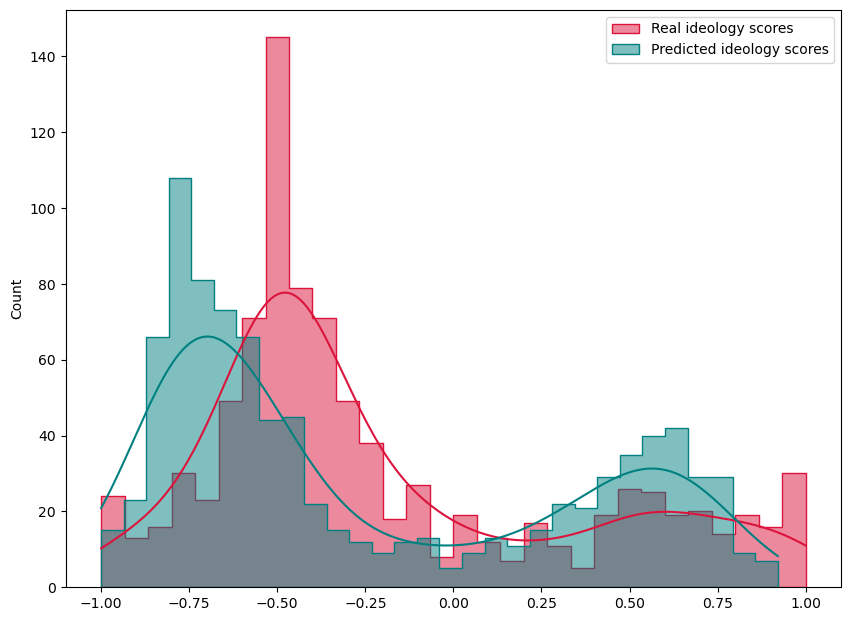

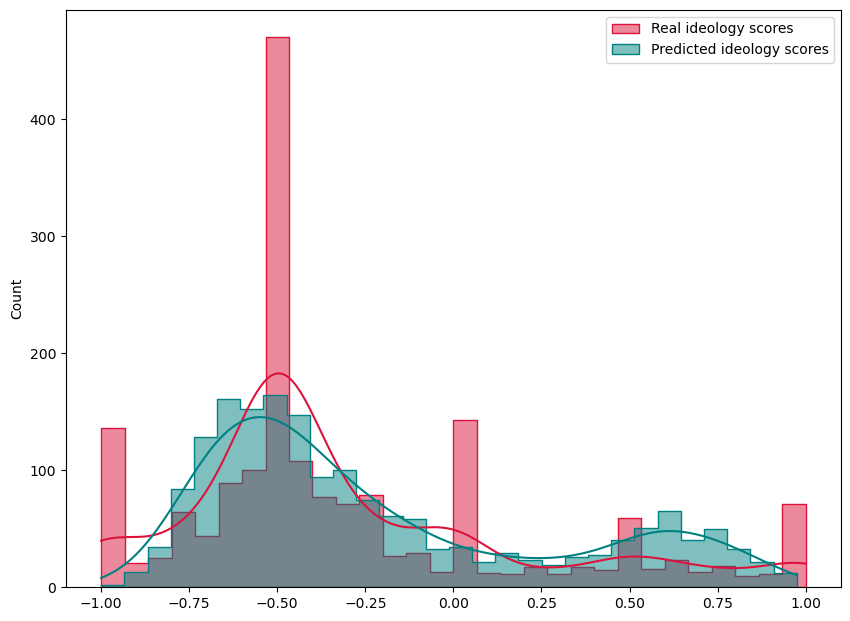

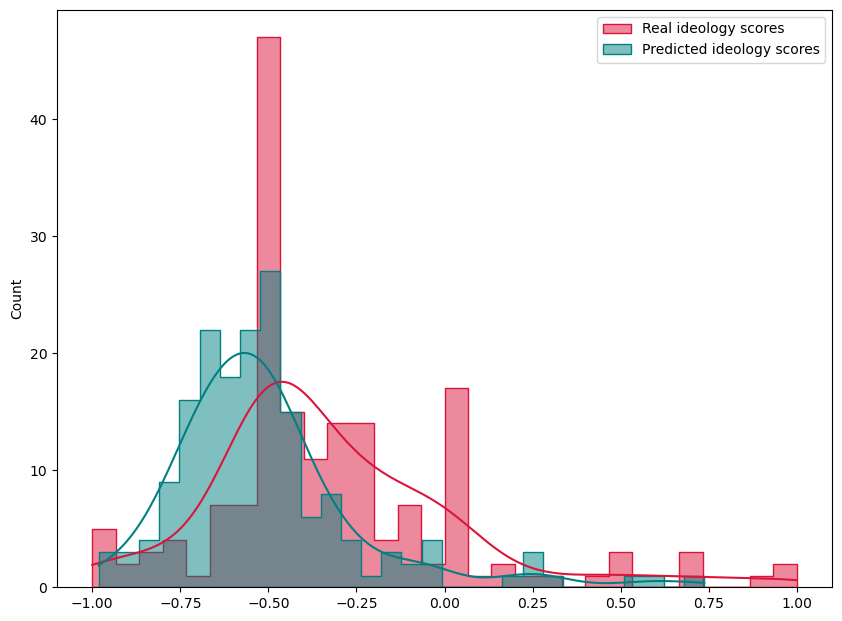

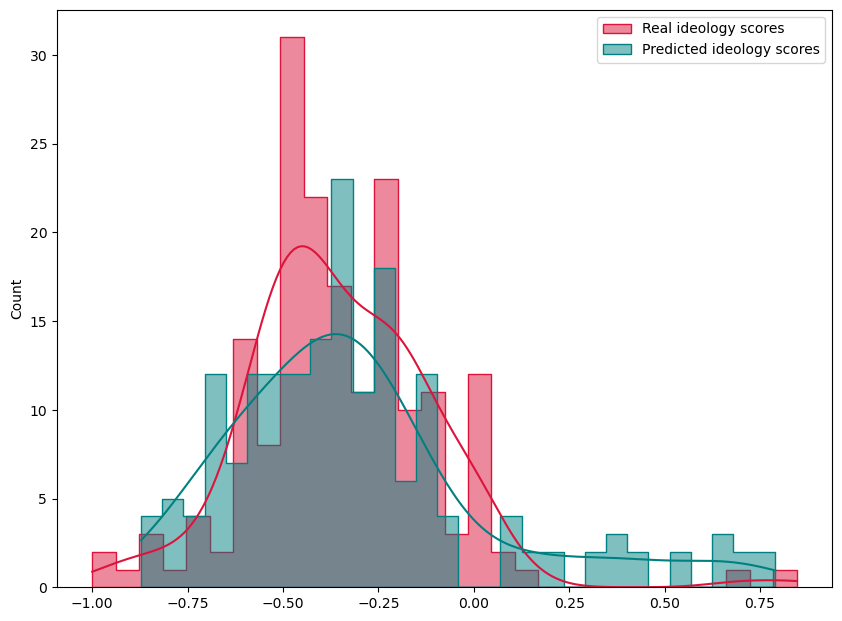

In [14]:
experiments = []

for ds in datasets:
    item = {}
    item["dataset"] = ds

    G, users_embeddings, labels, allsides_scores, node_id_map = get_data(f"data/{ds}/")

    train_allsides = select_10_percent(allsides_scores)
    test_allsides = {k: v for k, v in allsides_scores.items() if k not in train_allsides}
    real = list(test_allsides.values())

    # My method
    user_emb = EchoGAE_algorithm(G, user_embeddings= users_embeddings, algorithm="GAE", show_progress=False, hidden_channels = 20, out_channels=10, epochs=300)

    all_ideologies = ideology_detection(user_emb)

    pred = all_ideologies[list(test_allsides.keys())]

    kendall = kendalltau(real, pred)[0]
    kendall_ = kendalltau(real, -1.0 * pred)[0]

    item["kendalltau"] = max(kendall, kendall_)

    print(f"My metric {ds}: kendall ({kendall:.3f}, {kendall_:.3f})", end=" -- ")

    my_mae = min(mae(real, pred), mae(real, -1.0 * pred))
    my_mse = min(mse(real, pred), mse(real, -1.0 * pred))

    item["mae"] = my_mae
    item["mse"] = my_mse

    print(f"MAE: {my_mae:.3f}", end=" -- ")
    print(f"MSE: {my_mse:.3f}")

    # Plot
    if mae(real, pred) <= mae(real, -1.0 * pred):
        plot_ideology(real, pred, name=f"plots/{ds}.png")
    else:
        plot_ideology(real, -1.0 * pred, name=f"plots/{ds}.png")


    # # Baseline
    # G_, core_nodes = add_ideology_to_graph_22(G, ideologies_dict=train_allsides)
    # opinions = opinion_model(G_, core_nodes=core_nodes)

    # pred_bl = opinions[list(test_allsides.keys())]

    # baseline_kendall = kendalltau(real, pred_bl)[0]

    # item["baseline_kendall"] = baseline_kendall

    # print(f"Baseline {ds}: {baseline_kendall:.3f}", end=" -- ")

    # bl_mae = mae(real, pred_bl)
    # bl_mse = mse(real, pred_bl)

    # print(f"MAE: {bl_mae:.3f}", end=" -- ")
    # print(f"MSE: {bl_mse:.3f}")

    # item["baseline_mae"] = bl_mae
    # item["baseline_mse"] = bl_mse

    experiments.append(item)

In [18]:
experiments

[{'dataset': 'gun',
  'kendalltau': 0.4451815673436533,
  'mae': 0.2913472688781175,
  'mse': 0.13455720581794978,
  'baseline_kendall': 0.4654211222846876,
  'baseline_mae': 0.2714414634098807,
  'baseline_mse': 0.11120672719681468},
 {'dataset': 'abortion',
  'kendalltau': 0.30138434873502556,
  'mae': 0.3230962560369144,
  'mse': 0.17762807180685863,
  'baseline_kendall': 0.3151504446051592,
  'baseline_mae': 0.2693950311610931,
  'baseline_mse': 0.1359103203751322},
 {'dataset': 'super_bowl',
  'kendalltau': 0.06175072722936452,
  'mae': 0.35198308991756544,
  'mse': 0.22918909157777645,
  'baseline_kendall': 0.181809339778257,
  'baseline_mae': 0.2527171274825073,
  'baseline_mse': 0.14708851501817105},
 {'dataset': 'sxsw',
  'kendalltau': 0.11756788162959338,
  'mae': 0.28125814638275776,
  'mse': 0.1477144176790382,
  'baseline_kendall': 0.03742771525734423,
  'baseline_mae': 0.185370869690949,
  'baseline_mse': 0.06489360675466906}]

In [19]:
df_idol = pd.DataFrame(experiments)
df_idol

,dataset,kendalltau,mae,mse,baseline_kendall,baseline_mae,baseline_mse
0,gun,0.445182,0.291347,0.134557,0.465421,0.271441,0.111207
1,abortion,0.301384,0.323096,0.177628,0.315150,0.269395,0.135910
2,super_bowl,0.061751,0.351983,0.229189,0.181809,0.252717,0.147089
3,sxsw,0.117568,0.281258,0.147714,0.037428,0.185371,0.064894


In [21]:
df_idol.to_csv("experiments_april_14_ideology.csv")

In [27]:
G = nx.read_gml("garimella_datasets/clean_graphs/indiana.gml")

In [28]:
# convert node labels to integers
node_id_map = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, node_id_map)

In [29]:
# remove nodes where degree is 1
nodes_to_keep = [node for node in G.nodes() if G.degree(node) > 1]
G = G.subgraph(nodes_to_keep)

In [30]:
# import asyn_fluidc


In [31]:
mem = asyn_fluidc(G, k=2, seed=42, max_iter=1000)

In [32]:
mem = list(mem)

In [33]:
# mem

In [34]:
membership = []

for node in G.nodes():
    if node in mem[0]:
        membership.append(0)
    else:
        membership.append(1)

membership = np.array(membership)

In [35]:
Sigma(G, node_color= membership)

Sigma(nx.Graph with 369 nodes and 751 edges)

In [36]:
nodes_0 = np.array(list(mem[0]))
nodes_1 = np.array(list(mem[1]))

In [37]:
# membership = community_detection(G, 2)
# membership = np.array(membership)

# nodes_0 = np.where(membership == 0)[0]
# nodes_1 = np.where(membership == 1)[0]

# nodes_0 = np.array(mem[0])
# nodes_1 = np.array(mem[1])

rwc = RWC_jity(G, nodes_0, nodes_1)

rwc

: 

: 

# Garimella Datasets:

In [5]:
controversial = ['indiasdaughter',
 'beefban',
 'gunsense',
 'nemtsov',
 'baltimore',
 'leadersdebate',
 'ukraine',
 'netanyahu',
 'ultralive',
 'russia_march',
 'indiana']


non_controversial = [
 'sxsw',
 'nepal',
 'germanwings',
 'jurassicworld',]


all_datasets = controversial + non_controversial

In [7]:
experiments = []
for d in all_datasets:
    item = {}
    item["dataset"] = d

    print(f"{d}: ", end="")
    G, users_embeddings, labels = get_data_garimella(d)

    
    user_emb = EchoGAE_algorithm(G, user_embeddings=users_embeddings,algorithm="GAE", show_progress=False, hidden_channels = 20, out_channels=10, epochs=300)

    ecm = EchoChamberMeasure(user_emb, labels)
    score = ecm.echo_chamber_index()


    item["our_score"] = score

    print(f"Our score: {score:.3f} -- ", end="")


    # RWC
    # membership = community_detection(G, 2)
    # membership = np.array(membership)
    # nodes_0 = np.where(membership == 0)[0]
    # nodes_1 = np.where(membership == 1)[0]

    mem = asyn_fluidc(G, k=2, seed=42, max_iter=1000)
    mem = list(mem)

    nodes_0 = np.array(list(mem[0]))
    nodes_1 = np.array(list(mem[1]))

    item["RWC"] = RWC_jity(G, nodes_0, nodes_1)
    print(f"RWC: {item['RWC']:.3f} -- ", end="")

    membership = []
    for node in G.nodes():
        if node in nodes_0:
            membership.append(0)
        else:
            membership.append(1)


    # Venezuala
    G_ven, core_nodes = add_ideology_to_graph(G, membership, percentage=0.05)
    opinions = opinion_model(G_ven, core_nodes=core_nodes)
    polarization_index = get_polarization_index(opinions)[0]

    item["Venezuela"] = polarization_index
    print(f"Venezuela: {polarization_index:.3f} \n\n")

    experiments.append(item)

indiasdaughter: Our score: 0.526 -- RWC: 0.470 -- Venezuela: 0.305 


beefban: Our score: 0.569 -- RWC: 0.578 -- Venezuela: 0.585 


gunsense: Our score: 0.608 -- RWC: 0.345 -- Venezuela: 0.298 


nemtsov: Our score: 0.531 -- RWC: 0.635 -- Venezuela: 0.293 


baltimore: Our score: 0.531 -- RWC: 0.649 -- Venezuela: 0.418 


leadersdebate: Our score: 0.529 -- RWC: 0.334 -- Venezuela: 0.061 


ukraine: Our score: 0.561 -- RWC: 0.657 -- Venezuela: 0.252 


netanyahu: Our score: 0.590 -- RWC: 0.691 -- Venezuela: 0.452 


ultralive: Our score: 0.652 -- RWC: 0.251 -- Venezuela: 0.065 


russia_march: Our score: 0.591 -- RWC: 0.810 -- Venezuela: 0.636 


indiana: Our score: 0.617 -- RWC: 0.667 -- Venezuela: 0.032 


sxsw: Our score: 0.440 -- RWC: 0.619 -- Venezuela: 0.227 


nepal: Our score: 0.415 -- RWC: 0.400 -- Venezuela: 0.122 


germanwings: Our score: 0.418 -- RWC: 0.339 -- Venezuela: 0.076 


jurassicworld: Our score: 0.486 -- RWC: 0.659 -- Venezuela: 0.328 




In [8]:
df_garimella = pd.DataFrame(experiments)

In [9]:
df_garimella

,dataset,our_score,RWC,Venezuela
0,indiasdaughter,0.525818,0.469999,0.305254
1,beefban,0.568842,0.578262,0.584766
2,gunsense,0.608086,0.345146,0.297537
3,nemtsov,0.530831,0.634856,0.293083
4,baltimore,0.531463,0.648900,0.418089
5,leadersdebate,0.529252,0.334374,0.061392
6,ukraine,0.561221,0.657284,0.252218
7,netanyahu,0.589537,0.691091,0.451878
8,ultralive,0.652274,0.251159,0.064784
9,russia_march,0.590543,0.810311,0.636099


# Ablation Study

In [12]:
from scipy.stats import pearsonr

In [13]:
datasets = ["gun", "abortion", "super_bowl", "sxsw"]

In [14]:
experiments = []

for ds in datasets:
    item = {}
    item["dataset"] = ds

    G, users_embeddings, labels, allsides_scores, node_id_map = get_data(f"data/{ds}/")
    real = list(allsides_scores.values())

    def analyze_ideology(user_emb, dict_prefix):
        ecm = EchoChamberMeasure(user_emb, labels)
        eci = ecm.echo_chamber_index()
        item[dict_prefix + "echo_chamber_index"] = eci

        print(f"Echo chamber index: {eci:.3f}", end=" -- ")


        all_ideologies = ideology_detection(user_emb)

        pred = all_ideologies[list(allsides_scores.keys())]

        # kendall, p_value = kendalltau(real, pred)
        # kendall_, p_value_ = kendalltau(real, -1.0 * pred)
        # kendall = max(kendall, kendall_)

        # item[dict_prefix + "kendalltau"] =  kendall

        # print(f"kendall : {kendall:.3f}, p_values({p_value:.4f}, {p_value:.4f})", end=" -- ")

        # Pearson
        pearson, p_value = pearsonr(real, pred)
        pearson_, p_value_ = pearsonr(real, -1.0 * pred)
        pearson = max(pearson, pearson_)

        item[dict_prefix + "pearson"] =  pearson

        print(f"Pearson : {pearson:.3f}, p_values({p_value:.4f}, {p_value:.4f})", end=" -- ")

        my_mae = min(mae(real, pred), mae(real, -1.0 * pred))
        my_mse = min(mse(real, pred), mse(real, -1.0 * pred))

        item[dict_prefix +"mae"] = my_mae
        item[dict_prefix +"mse"] = my_mse

        print(f"MAE: {my_mae:.3f}", end=" -- ")
        print(f"MSE: {my_mse:.3f}")

    # With user embeddings
    user_emb = EchoGAE_algorithm(G, user_embeddings=users_embeddings,algorithm="GAE", show_progress=False, hidden_channels = 20, out_channels=10, epochs=300)
    print(f"Dataset: {ds}")
    print("With user embeddings: ", end="")
    analyze_ideology(user_emb, "with_")

    # Without user embeddings
    user_emb = EchoGAE_algorithm(G, algorithm="GAE", show_progress=False, hidden_channels = 20, out_channels=10, epochs=300)
    print("Without user embeddings: ", end="")
    analyze_ideology(user_emb, "without_")

    print("\n\n")

    experiments.append(item)



Dataset: gun
With user embeddings: Echo chamber index: 0.714 -- Pearson : 0.794, p_values(0.0000, 0.0000) -- MAE: 0.289 -- MSE: 0.132
Without user embeddings: Echo chamber index: 0.571 -- Pearson : 0.736, p_values(0.0000, 0.0000) -- MAE: 0.304 -- MSE: 0.143



Dataset: abortion
With user embeddings: Echo chamber index: 0.626 -- Pearson : 0.650, p_values(0.0000, 0.0000) -- MAE: 0.321 -- MSE: 0.176
Without user embeddings: Echo chamber index: 0.550 -- Pearson : 0.647, p_values(0.0000, 0.0000) -- MAE: 0.292 -- MSE: 0.148



Dataset: super_bowl
With user embeddings: Echo chamber index: 0.485 -- Pearson : 0.030, p_values(0.6764, 0.6764) -- MAE: 0.361 -- MSE: 0.232
Without user embeddings: Echo chamber index: 0.437 -- Pearson : 0.033, p_values(0.6509, 0.6509) -- MAE: 0.426 -- MSE: 0.312



Dataset: sxsw
With user embeddings: Echo chamber index: 0.465 -- Pearson : 0.211, p_values(0.0027, 0.0027) -- MAE: 0.274 -- MSE: 0.140
Without user embeddings: Echo chamber index: 0.464 -- Pearson : 0.079,

In [15]:
df = pd.DataFrame(experiments)
df

,dataset,with_echo_chamber_index,with_pearson,with_mae,with_mse,without_echo_chamber_index,without_pearson,without_mae,without_mse
0,gun,0.714427,0.793926,0.288701,0.131562,0.570983,0.736439,0.304015,0.143229
1,abortion,0.626222,0.650428,0.321449,0.176189,0.549775,0.646747,0.291838,0.147802
2,super_bowl,0.484630,0.030159,0.361154,0.232464,0.437474,0.032695,0.426200,0.312231
3,sxsw,0.465053,0.211438,0.274345,0.140303,0.464228,0.078945,0.421417,0.286497
